In [1]:
from cosmic.sample.initialbinarytable import InitialBinaryTable
from cosmic.evolve import Evolve
from cosmic.utils import convert_kstar_evol_type
from cosmic.plotting import evolve_and_plot

import numpy as np
import matplotlib.pyplot as plt
import math
import tqdm

In [2]:
# Helper functions and variables for unit conversions

def aui_to_porb(aui, m_tot):
    # aui: a list of values, initial separation in AU
    # m_tot: a list of values, total mass in M_sun
    # result: a list of values, orbital period in given condition in days
    res = []
    for i in range(len(aui)):
        res.append((1/m_tot[i]**0.5) * (aui[i]**1.5) * 365)
    return res

# Used to convert separation in R_sun into AU
unit_factor = 1 / 215.032

# Helper function: given an array of data and an array of target,
# return an array of index that is nearest to the target value.
import math 
def findNearestList(data, targetList):
    res = []
    for num in targetList:
        res.append(findNearest(data, num))
    return res

def findNearest(data, target):
    n = len(data)
    res = -1
    minDiff = 10**5
    for i in range(n):
        if data[i] == 10**(-5):
            continue
        if abs(target - data[i]) <= minDiff:
            res = i
            minDiff = abs(target - data[i])
    return res

In [3]:
# Default BSEDict
BSEDict = {'xi': 1.0, 'bhflag': 1, 'neta': 0.5, 'windflag': 3, 'wdflag': 1, 'alpha1': 1.0, 'pts1': 0.001, 
           'pts3': 0.02, 'pts2': 0.01, 'epsnov': 0.001, 'hewind': 0.5, 'ck': 1000, 'bwind': 0.0, 'lambdaf': 0.0, 
           'mxns': 3.0, 'beta': -1.0, 'tflag': 1, 'acc2': 1.5, 'grflag' : 1, 'remnantflag': 4, 'ceflag': 0, 
           'eddfac': 1.0, 'ifflag': 0, 'bconst': 3000, 'sigma': 265.0, 'gamma': -2.0, 'pisn': 45.0, 
           'natal_kick_array' : [[-100.0,-100.0,-100.0,-100.0,0.0], [-100.0,-100.0,-100.0,-100.0,0.0]], 
           'bhsigmafrac' : 1.0, 'polar_kick_angle' : 90, 
           'qcrit_array' : [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0], 
           'cekickflag' : 2, 'cehestarflag' : 0, 'cemergeflag' : 0, 'ecsn' : 2.25, 'ecsn_mlow' : 1.6, 
           'aic' : 1, 'ussn' : 0, 'sigmadiv' :-20.0, 'qcflag' : 1, 'eddlimflag' : 0, 
           'fprimc_array' : [2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0], 
           'bhspinflag' : 0, 'bhspinmag' : 0.0, 'rejuv_fac' : 1.0, 'rejuvflag' : 0, 'htpmb' : 1, 'ST_cr' : 1, 
           'ST_tide' : 1, 'bdecayfac' : 1, 'rembar_massloss' : 0.5, 'kickflag' : 0, 'zsun' : 0.014, 'bhms_coll_flag' : 0, 
           'don_lim' : -1, 'acc_lim' : -1, 'rtmsflag' : 0, 'wd_mass_lim': 1}

In [4]:
NUM_DICT = 2000
NUM_SEP = 400

MASS_1 = 7
MASS_2 = 1
MASS_TOT = 8

ECC = 0

SEP_START = 2
SEP_END = 8

LAMBDA_START = -100
LAMBDA_END = 0

SOLAR_MET = 0.02

TPHYS_LIM = 200

In [11]:
# List of initial conditions for simulation later

m1_list = [MASS_1 for i in range(NUM_SEP)]
m2_list = [MASS_2 for i in range(NUM_SEP)]
mtot_list = [MASS_TOT for i in range(NUM_SEP)]
ai_list = np.linspace(SEP_START, SEP_END, NUM_SEP)
porb_i_list = aui_to_porb(ai_list, mtot_list)

ecc_list = [ECC for i in range(NUM_SEP)]
tphysf_list = [TPHYS_LIM for i in range(NUM_SEP)]
kstar1_list = [1 for i in range(NUM_SEP)]
kstar2_list = [1 for i in range(NUM_SEP)]
metallicity_list = [SOLAR_MET for i in range(NUM_SEP)] # solar metallicity

In [6]:
binary_set = InitialBinaryTable.InitialBinaries(m1=m1_list, m2=m2_list, 
                                                porb=porb_i_list, ecc=ecc_list, 
                                                tphysf=tphysf_list, kstar1=kstar1_list, kstar2=kstar2_list, 
                                                metallicity=metallicity_list)

Now we calculate the value of $\lambda_{\mathrm{CE}}$ based on the following formulas.

$$
\lambda_{\mathrm{CE}} = 
\begin{cases}
2 \lambda_2 & (M_{\mathrm{env}} = 0), \\
2 \lambda_2 + 2 M_{\mathrm{env}}^{0.5} (\lambda_1 - \lambda_2) & (0 < M_{\mathrm{env}} \leq 1), \\
2 \lambda_1 & (M_{\mathrm{env}} > 1).
\end{cases}
$$

For HG and GB stars:
$$
\lambda_1 = \min\left( 0.80, \frac{3}{2.4 + M^{-3/2}} - 0.15 \lg L \right).
$$

For CHeB, E-AGB, or TP-AGB stars:
$$
\lambda_3 = \min(0.9, 0.58 + 0.75 \lg M) - 0.08 \lg L
$$
and 
$$
\lambda_1 = \begin{cases}
\min(0.8, 1.25 - 0.15 \lg L, \lambda_3) & \text{CHeB, E-AGB}, \\
\max(-3.5-0.75 \lg M + \lg L, \lambda_3) & \text{TP-AGB}.
\end{cases}
$$

In [7]:
def lambda_CE(bpp_row, m1):
    mass = bpp_row['mass_1']
    lum = bpp_row['lum_1']
    star = bpp_row['kstar_1']
    menv = bpp_row['menv_1']
    rad = bpp_row['rad_1']
    rad_zams = mass if m1 <= 1 else mass ** 0.6

    if menv >= 1:
        if star == 2 or star == 3: 
            # If the star is HG or GB
            lambda_1 = min(0.80, (3 / (2.4 + mass ** (-3/2))) - 0.15 * math.log(lum, 10))
        elif star == 4 or star == 5 or star == 6:
            # If the star is CHeB, E-AGB, or TP-AGB
            lambda_3 = min(0.9, 0.58 + 0.75 * math.log(mass, 10)) - 0.08 * math.log(lum, 10)
            if star == 4 or star == 5:
                # If the star is CHeB or E-AGB
                lambda_1 = min(0.8, 1.25 - 0.15 * math.log(lum, 10), lambda_3)
            else:
                # If the star is TP-AGB
                lambda_1 = max(-3.5 - 0.75 * math.log(mass, 10) + math.log(lum, 10), lambda_3)
        else:
            # Should not reach here
            lambda_1 = 0
        return 2 * lambda_1
        
    elif 0 < menv < 1:
        lambda_2 = 0.42 * (rad_zams / rad) ** 0.4
        lambda_1 = min(0.80, (3 / (2.4 + mass ** (-3/2))) - 0.15 * math.log(lum, 10))
        return 2 * (lambda_2 + menv**0.5 * (lambda_1 - lambda_2))
    
    else:
        lambda_2 = 0.42 * (rad_zams / rad) ** 0.4
        return lambda_2

In [21]:
data1 = np.zeros(NUM_SEP)

bpp, bcm, initC, kick_info = Evolve.evolve(initialbinarytable=binary_set, BSEDict=BSEDict)
bpp['sep in AU'] = bpp['sep'] * unit_factor

for i in tqdm.tqdm(range(NUM_SEP)):
    single_bpp = bpp.loc[i].copy()
    cond1 = (single_bpp['evol_type']==7)
    # cond2 = (single_bpp['evol_type']==8)
    
    specific_row1 = single_bpp[(cond1)].iloc[0]
    
    data1[i] = lambda_CE(specific_row1, MASS_1)

print(data1.tolist())

100%|███████████████████████████████████████| 400/400 [00:00<00:00, 1081.67it/s]

[1.328838983810069, 1.327462414508864, 1.3260935298603327, 1.3247315610302717, 1.3233701062095748, 1.3220225858629522, 1.3206913912102083, 1.3193731487631788, 1.3180606184665251, 1.3167532257142252, 1.315448277641708, 1.3141570429378366, 1.3128834176687973, 1.3116138139923486, 1.3103472784116692, 1.3091304353780235, 1.3078416051367825, 1.3066062169918713, 1.3053727994751472, 1.3041398749473454, 1.3029288552397194, 1.301724197256633, 1.3005200148588592, 1.299307619160248, 1.298137727257229, 1.2969600883717864, 1.2957810045635965, 1.294612841639015, 1.293459790180403, 1.292305047054243, 1.2911218178834156, 1.290018367619541, 1.2888859040528517, 1.2877490938449225, 1.2866341887430808, 1.2855221546375533, 1.2844050876200546, 1.2833053240570889, 1.2822119997602621, 1.2811127416891313, 1.2800297198423989, 1.278953341030155, 1.277869924044111, 1.276805079077957, 1.2757438296684347, 1.2746742306173362, 1.2736289162308683, 1.272581039699659, 1.2714753987341383, 1.2704992779336537, 1.26946322398

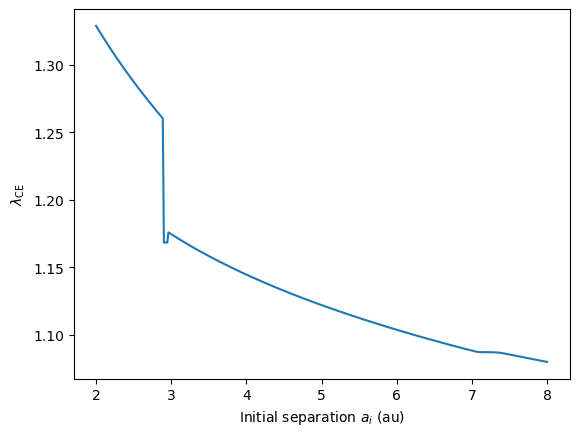

In [9]:
# Create the plot
plt.plot(ai_list, data1)

# Add titles and labels
plt.xlabel(r'Initial separation $a_i$ (au)')
plt.ylabel(r'$\lambda_{\mathrm{CE}}$')

# Show the plot
plt.show()

In [18]:
x_list = [2.4404761904761902, 2.642857142857143, 2.833333333333333, 3.083333333333333, 3.321428571428571, 3.6071428571428568, 3.880952380952381, 4.142857142857142, 4.357142857142857, 4.583333333333333, 4.809523809523809, 5.023809523809524, 5.214285714285714, 5.44047619047619, 5.654761904761904, 5.845238095238095, 6.071428571428571, 6.285714285714286, 6.523809523809524, 6.75, 6.976190476190475, 7.154761904761904, 7.357142857142857, 7.559523809523809, 7.702380952380952]
lambdaFitting = [-2.0, -2.0, -2.049999999999997, -1.8999999999999915, -1.8999999999999915, -1.8999999999999915, -1.9499999999999886, -1.7999999999999972, -1.3499999999999943, -1.0, -0.8499999999999943, -0.6999999999999886, -0.6499999999999915, -0.5999999999999943, -0.5999999999999943, -0.6499999999999915, -0.6499999999999915, -0.75, -1.0, -1.3499999999999943, -1.8499999999999943, -1.0, -1.0999999999999943, -1.1999999999999886, -1.25]
for i in range(len(lambdaFitting)):
    lambdaFitting[i] *= -1

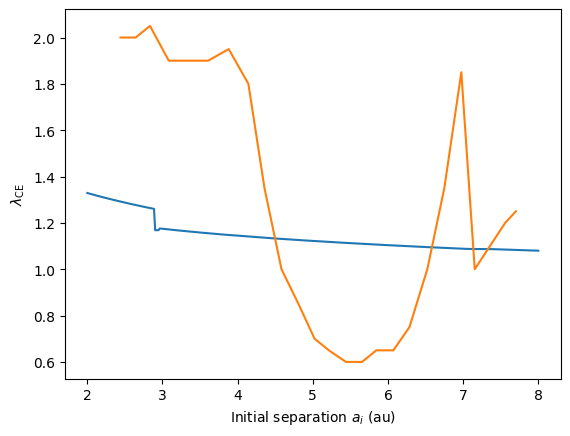

In [20]:
# Create the plot
plt.plot(ai_list, data1, label = 'COSMIC')
plt.plot(x_list, lambdaFitting, label = 'MESA')

# Add titles and labels
plt.xlabel(r'Initial separation $a_i$ (au)')
plt.ylabel(r'$\lambda_{\mathrm{CE}}$')

# Show the plot
plt.show()